In [192]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import dependencies and data

In [285]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import HuberRegressor, LinearRegression, LogisticRegression, ElasticNet, PassiveAggressiveRegressor
from sklearn.svm import SVC, LinearSVC, LinearSVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

Acquiring the data

In [194]:
'''
Data paths for kaggle online working

df = pd.read_csv(r'/kaggle/input/titanic/train.csv')
df_test = pd.read_csv(r'/kaggle/input/titanic/test.csv')
df_gender = pd.read_csv(r'/kaggle/input/titanic/gender_submission.csv')
'''
# Data paths for desktop offline working

df = pd.read_csv(r'./input/train.csv')
df_test = pd.read_csv(r'./input/test.csv')
df_gender = pd.read_csv(r'./input/gender_submission.csv')

# Exploring the data

First we explore the features available in the data.

In [195]:
df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

Second, we preview the data in order to identify further information regarding the features.

In [196]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can find 5 categorical features (Survived, Pclass, Sex, Cabin and Embarked) and 4 continuous fetures (Age, SibSp, Parch and Fare).

Ticket and Cabin are mixed features, harder to deal with. 

Name feature won't be taken into account as is a proxy for PassengerId.

We can find the description for the variables here: https://www.kaggle.com/c/titanic/data

### Distribution os feature values 

In [197]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Total samples are 891 for the training test.
- Survived is a category with 0 or 1 values and present a 38% survival rate.
- Most passengers (> 75%) did not travel with parents or children.
- Passengers on the titanic were mostly young since q75 is at age 38 and max age is 80.

In [198]:
df.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Kelly, Mr. James",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


- Sex values only have 2 possible values.
- Ticket and Cabin values present a high rate of duplicates
- Embarked present 3 values with the top value being S (Southampton, the first of the 3 ports before the accident took place)

In [199]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [200]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


In [201]:
print(df.isnull().sum())
print('/'*50)
print(df_test.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
//////////////////////////////////////////////////
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## Correlation of features. 

We will check survival correlation between the categorical features.

In [202]:
df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [203]:
df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [204]:
df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Since the Cabin value may be biased towards the declarations took after the accident we will transform the values to a binary ditribution and check if this assumption could be right.

In [205]:
df['Cabin'] = df['Cabin'].notnull().astype(int)
df[['Cabin', 'Survived']].groupby(['Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Cabin,Survived
1,1,0.666667
0,0,0.299854


In [221]:
df_test['Cabin'] = df_test['Cabin'].notnull().astype(int)

We can see a clear correlation between survival and having the cabin value available and thus we can assume there is a bias in the feature values.

## Visualizations

We can look at the distribution of survivors by age.

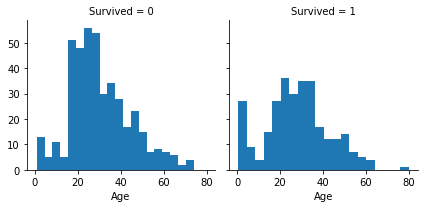

In [206]:
g = sns.FacetGrid(df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

And categorize it by class.

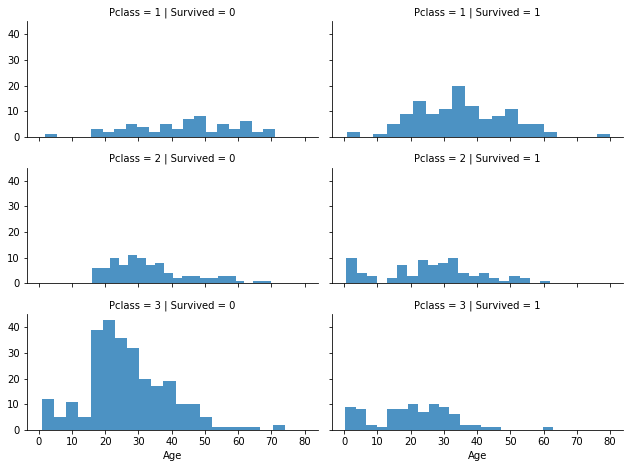

In [207]:
grid = sns.FacetGrid(df, col='Survived', row='Pclass', height=2.2, aspect=2)
grid.map(plt.hist, 'Age', alpha=.8, bins=20)
grid.add_legend()
plt.show()

We can also look at the port of embarking and figure out if it had a significant impact on survival rate.

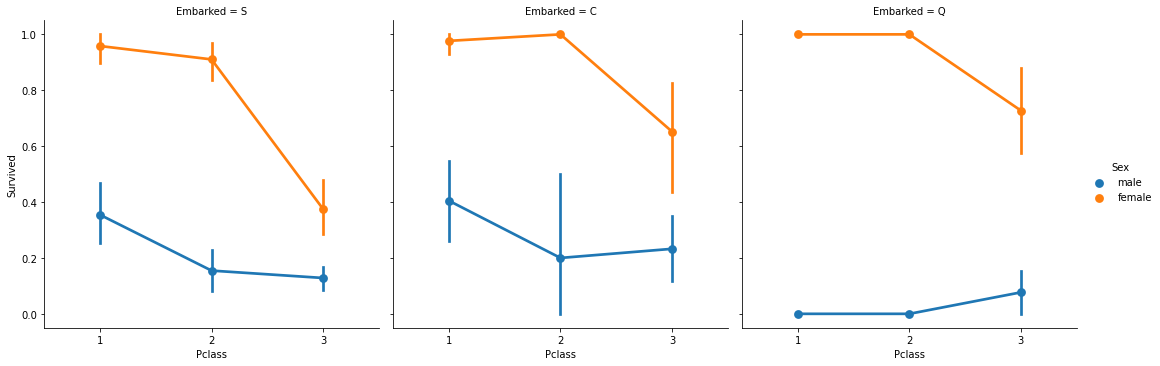

In [208]:
sns.catplot(x='Pclass',col='Embarked',y='Survived',hue='Sex',data=df,kind='point')
plt.show()

We can see that males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports. This could mean that emarking port could have some relevance for certain groups.

Let's take a look at it with more depth.

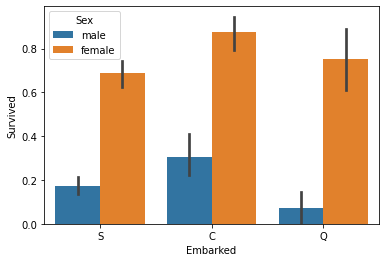

In [209]:
sns.barplot(x='Embarked',y='Survived',hue='Sex',data=df)
plt.show()

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


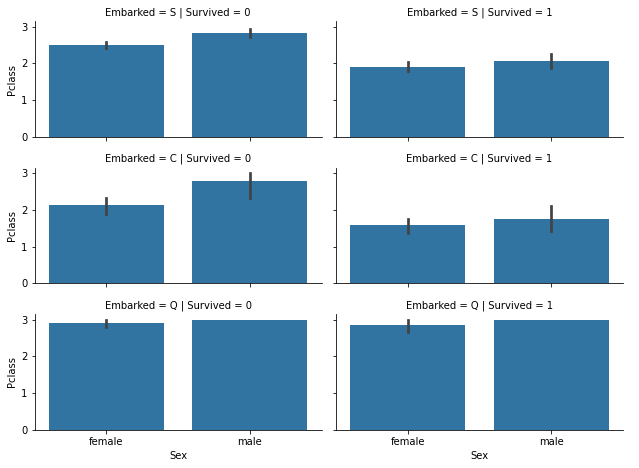

In [210]:
grid = sns.FacetGrid(df, col='Survived', row='Embarked', height=2.2, aspect=2)
grid.map(sns.barplot, 'Sex', 'Pclass')
grid.add_legend()
plt.show()

# Dataframe Transformations

In [211]:
# model_col = ['Survived', 'Pclass', 'Age_new', 'SibSp', 'Parch', 'Sex_new', 'Cabin_new']

## Transformations to training and testing dataset

In this part we will transform training and testing datasets into workable datasets.

First we will drop the features we didn't see fit for the problem.

In [212]:
df = df.drop(['Ticket'], axis=1)
df_test = df_test.drop(['Ticket'], axis=1)

After that we will take a look to the Name feature.

In [213]:
df['Name'].tail()

886                       Montvila, Rev. Juozas
887                Graham, Miss. Margaret Edith
888    Johnston, Miss. Catherine Helen "Carrie"
889                       Behr, Mr. Karl Howell
890                         Dooley, Mr. Patrick
Name: Name, dtype: object

After reviewing the data we can see that the passengers had a tittle attaached to their names.

Let's find out what are the most common titles by extracting them from the names.

In [214]:
# every title is before a. and after a blank space so we will look there

for dataset in [df, df_test]:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

print(df['Title'].value_counts().sum())
pd.crosstab(df['Title'], df['Sex'])

891


Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


According to the list we can assume 2 things:

- Titles in names were universal.
- Some passengers had titles beyond Mrs and Mr which can indicate a higher status in society.

We can change rare titles to a new variable "HighStatus" and see the correlation with survival.
We can also change the rest of the titles and look for further correlations.

In [215]:
for dataset in [df, df_test]:
    dataset['HighStatus'] = dataset['Title'].isin(
        ['Lady', 'Countess','Capt', 'Col',	'Don', 'Dr', 'Major', 'Master', 'Rev', 'Sir', 'Jonkheer', 'Dona']
        ).astype(int)

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    dataset['MiddleClass'] = dataset['Title'].isin([
         'Miss', 'Mrs', 'Mr']
         ).astype(int)

In [216]:
df[['HighStatus', 'Survived']].groupby(['HighStatus'], as_index=False).mean()

,HighStatus,Survived
0,0,0.375604
1,1,0.492063


Half of the people with a social title survived so we can assume this is a relevant feature.

Now we transform the Sex feature into a binary feature.

In [217]:
for dataset in [df, df_test]:
    dataset['Sex'] = (dataset['Sex'].values == 'female').astype(int)

One-hot encode of relevant variables.

In [341]:
for dataset in [df, df_test]:
    # define values
    data = dataset['Pclass']
    values = np.array(data)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    dataset[['Pclass1', 'Pclass2', 'Pclass3']] = onehot_encoded.astype(int)
    #df.drop('Pclass', axis=1, inplace=True)

## Completing the Age feature

Age is the only feature that has a relevant amount of NaN values.

The options are:

    1. Generate random numbers to fill the NaN values.
    2. Guess the age based on other features.

The best result will come, of course, doing the second option although it could be challenging.

Lest's try it out.

*vamos a probar a rellenar los valores con un modelo predictivo*

*Ahora mismo da igual que modelo utilicemos para la prediccion, todos dan un rmse de alrededor de 12 asi que estoy valorando dejar el kn reg como modelo preferido pero dal la explicacion sobre como todos son bastante similares y que predecir esta feature es bastante complicado*

In [339]:
cols = ['Pclass1', 'Pclass3', 'Age', 'SibSp', 'Parch', 'Cabin', 'HighStatus']

# para la prediccion de los modelos

agedropna = df[df['Age'].notna()][cols]
agetest_x = agedropna.drop('Age', axis=1)
agetest_y = agedropna['Age']
agepred_x = df[df['Age'].isna()][cols]

# para el testeo de las suposiciones

agepred_x_test0 = df_test[df_test['Age'].notna()][cols]
agepred_x_test =  agepred_x_test0.drop('Age', axis=1)

un monton de modelos para ensayar los resultados

In [346]:
Huber = HuberRegressor()
Linear = LinearRegression()
#LogisticReg = LogisticRegression()
SVR = LinearSVR()
Elastic=ElasticNet(random_state=0)
#PassiveAggressiveReg = PassiveAggressiveRegressor()
estimators = [Linear, SVR, Huber, Elastic]
for i in estimators:
    rmse_val = []
    reg = i.fit(agetest_x, agetest_y)
    print(str(i)+" Coefficients:", np.round(i.coef_,2))
    pred = i.predict(agepred_x_test)
    error = sqrt(mean_squared_error(df_test['Age'].dropna(),pred))
    rmse_val.append(error)
    print('RMSE value for k= ' , K , 'is:', error)
    print("**************************")
    curve = pd.DataFrame()
    curve[i] = rmse_val

LinearRegression() Coefficients: [11.3  -4.56 -3.41 -1.22 -3.76 -6.82]
RMSE value for k=  20 is: 12.287481566648598
**************************
LinearSVR() Coefficients: [ 8.   -3.62 -2.78 -0.92  1.   -6.62]
RMSE value for k=  20 is: 12.257467083282991
**************************
HuberRegressor() Coefficients: [10.55 -4.87 -2.87 -1.2  -2.78 -8.75]
RMSE value for k=  20 is: 12.17179166044886
**************************
ElasticNet(random_state=0) Coefficients: [ 1.91 -1.77 -2.4  -0.88  0.81 -0.13]
RMSE value for k=  20 is: 13.315302893809914
**************************


el ensayo con knneig sobre cual es el numero de k optimo

In [ ]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K, weights = 'distance')

    model.fit(agetest_x, agetest_y)  #fit the model
    pred = model.predict(agepred_x_test) #make prediction on test set
    error = sqrt(mean_squared_error(df_test['Age'].dropna(),pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [344]:
# 
knn = KNeighborsRegressor(n_neighbors = 8, weights = 'distance')
knn.fit(agetest_x, agetest_y)
agepred_y_test = knn.predict(agepred_x_test)

In [347]:
knn = KNeighborsRegressor(n_neighbors = 5)
knn.fit(agetest_x, agetest_y)
agepred_y = knn.predict(agepred_x)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

-----------------

# *CURRENTLY WORKING HERE*

revision visual de los resultados

In [345]:
df_age = pd.DataFrame()
df_age['True'] = df_test['Age'].dropna()
df_age['Predict'] = agepred_y_test
df_age

,True,Predict
0,34.5,25.6875
1,47.0,25.3750
2,62.0,34.1250
3,27.0,25.6875
4,22.0,24.7500
...,...,...
409,3.0,24.7500
411,37.0,43.1250
412,28.0,25.6875
414,39.0,44.5000


--------------

## Transformations to testing dataset

###

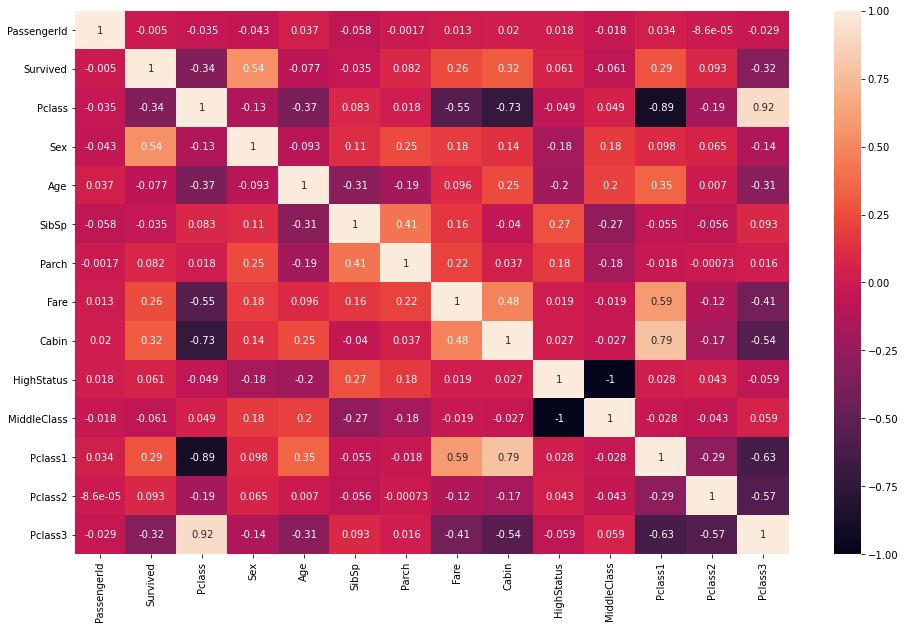

In [178]:
df_corr = df.corr()
plt.figure(figsize=(16,10))
sns.heatmap(df_corr, annot=True)
plt.show()

# MODEL

In [12]:
x_train = df.drop(columns = 'Survived')
y_train = df['Survived']
x_test = df_test_new.fillna(100).drop(columns = 'Survived')
y_test = df_test_new['Survived']

In [13]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
predictions = model.predict(X = x_test)
predictions

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [14]:
df_pred = pd.DataFrame()
df_pred['PassengerId'] = df_test['PassengerId']
df_pred['Survived'] = predictions
df_pred.to_csv('titanic_results.csv',index=False)

In [15]:
df_pred

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predictions
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predictions,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

Matriz de confusión
-------------------
[[261 157]
 [  0   0]]

El accuracy de test es: 62.44019138755981 %


print(
    classification_report(
        y_true = y_test,
        y_pred = predictions
    )
)

In [17]:
#print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [18]:
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#n_scores = cross_val_score(model, df_new2.drop(columns = "Survived"), df_new2['Survived'], scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')